## Imports

In [1]:
#!pip install gym[atari]
#!pip install autorom[accept-rom-license]

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gym
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from torchvision import transforms
import os

C:\Users\Master\anaconda3\envs\py311\Lib\site-packages\gym\envs\registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


## Render

In [3]:
#Render
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

## Hyperparameter

In [4]:
NUM_SAMPLES = 10000
BATCH_SIZE = 64
LEARNING_RATE = 2e-4
EPOCHS = 100
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LATENT_DIM = 100
IMG_SIZE = (210, 160)  # Original size of Breakout images (height, width)
CHANNELS = 3           # RGB images

## Generator

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.init_size = (IMG_SIZE[0] // 16, IMG_SIZE[1] // 16)  # Adjusting to image size
        # Linear layer to project latent space to a larger dimension
        self.l1 = nn.Sequential(nn.Linear(LATENT_DIM, 128 * self.init_size[0] * self.init_size[1]))
        
        # Define the convolutional blocks for upsampling and generating the image
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2), 
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32, 0.8),
            nn.ReLU(inplace=True),
            nn.Upsample(size=IMG_SIZE),  # Upsample to the target image size
            nn.Conv2d(32, CHANNELS, 3, stride=1, padding=1),
            nn.Tanh()  # Output activation to [-1, 1]
        )
        
    def forward(self, z):
        out = self.l1(z)  # Pass through linear layer
        out = out.view(out.size(0), 128, *self.init_size)  # Reshape for convolutional layers
        img = self.conv_blocks(out)  # Pass through convolutional blocks
        return img

## Discriminator

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Helper function to create a discriminator block
        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1),
                     nn.LeakyReLU(0.2, inplace=True)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))  # Optional batch normalization
            return block
        
        # Define the sequence of discriminator blocks
        self.model = nn.Sequential(
            *discriminator_block(CHANNELS, 64, bn=False),  # First block without batch normalization
            *discriminator_block(64, 128),  # Second block
            nn.Flatten(),  # Flatten the output
            nn.Linear(128 * (IMG_SIZE[0] // 4) * (IMG_SIZE[1] // 4), 1)  # Linear layer for final output
        )
        
    def forward(self, img):
        validity = self.model(img)  # Pass the image through the model
        return validity

In [7]:
# Function to initialize weights with a normal distribution
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('ConvTranspose') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

## Data

In [8]:
# Define a transformation to convert images to tensors and normalize them to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalization to [-1, 1]
])

# Function to get real data from the Breakout environment
def get_real_data():
    # Create the Breakout environment with RGB rendering
    env = gym.make('Breakout-v4', render_mode='rgb_array')
    env.reset()
    data = []
    for _ in range(NUM_SAMPLES):
        action = env.action_space.sample()  # Sample a random action
        # Take a step in the environment with the sampled action
        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        observation = transform(observation)  # Apply transformation to the observation
        data.append(observation)
        if done:
            env.reset()
    env.close()
    return torch.stack(data)  # Stack all observations into a single tensor

# Get real data and move it to the device
real_data = get_real_data().to(DEVICE)

C:\Users\Master\anaconda3\envs\py311\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


## Main Algorithm

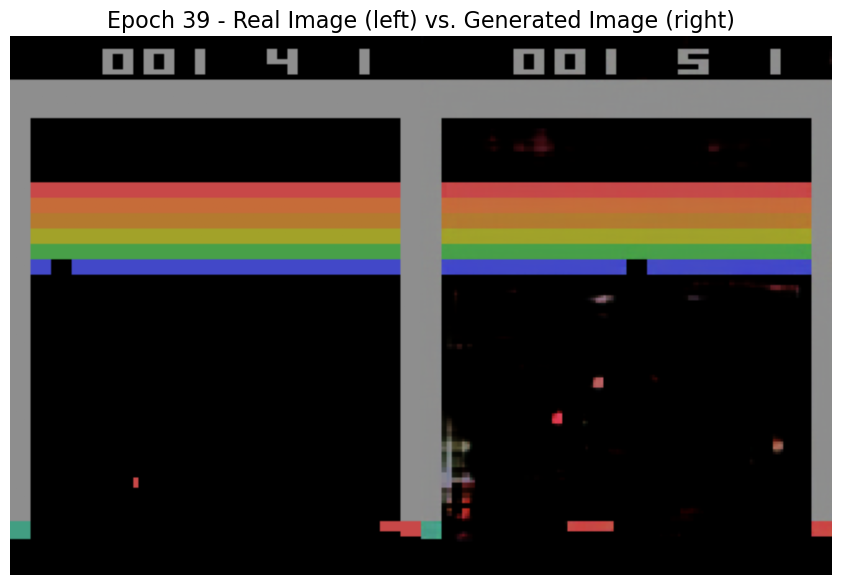

Epoch 39/100 - Discriminator Loss: 0.4123, Generator Loss: 1.5836


KeyboardInterrupt: 

In [9]:
# Define the adversarial loss function
adversarial_loss = nn.BCEWithLogitsLoss().to(DEVICE)

# Initialize the generator and discriminator
generator = Generator().to(DEVICE)
discriminator = Discriminator().to(DEVICE)

# Apply the weight initialization to both networks
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Define optimizers for both generator and discriminator
generator_optimizer = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

# Create input for the generator
fixed_noise = torch.randn(BATCH_SIZE, LATENT_DIM).to(DEVICE)

# Training loop
for epoch in range(EPOCHS):
    permutation = torch.randperm(NUM_SAMPLES)  # Shuffle indices
    generator_loss_list = []
    discriminator_loss_list = []
    
    for i in range(0, NUM_SAMPLES, BATCH_SIZE):
        indices = permutation[i:i+BATCH_SIZE]  # Get batch indices
        real_imgs = real_data[indices]  # Get real images batch
        real_imgs = real_imgs.to(DEVICE)
        valid = torch.ones(real_imgs.size(0), 1).to(DEVICE)  # Labels for real images
        fake = torch.zeros(real_imgs.size(0), 1).to(DEVICE)  # Labels for fake images
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        discriminator_optimizer.zero_grad()  # Reset gradients
        
        # Generate images
        z = torch.randn(real_imgs.size(0), LATENT_DIM).to(DEVICE)  # Sample random noise
        gen_imgs = generator(z)  # Generate images from noise
        
        # Calculate loss for real images
        real_validity = discriminator(real_imgs)
        d_real_loss = adversarial_loss(real_validity, valid)
        
        # Calculate loss for generated images
        fake_validity = discriminator(gen_imgs.detach())  # Detach to avoid training generator
        d_fake_loss = adversarial_loss(fake_validity, fake)
        
        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2
        
        d_loss.backward()  # Backprop
        discriminator_optimizer.step()  # Update discriminator weights
        discriminator_loss_list.append(d_loss.item())
        
        # -----------------
        #  Train Generator
        # -----------------
        generator_optimizer.zero_grad()  # Reset gradients
        
        # Generator tries to fool the discriminator
        validity = discriminator(gen_imgs)
        g_loss = adversarial_loss(validity, valid) 
        
        g_loss.backward()  # Backprop
        generator_optimizer.step()  # Update generator weights
        generator_loss_list.append(g_loss.item())
    
    # Visualization after each epoch
    generator.eval() 
    with torch.no_grad():
        sample_imgs = generator(fixed_noise).detach().cpu()
    generator.train()  # Set generator back to training mode
    
    # Select one real image and one generated image
    real_img = real_imgs[0].cpu().numpy()
    gen_img = sample_imgs[0].numpy()
    
    # Denormalize images to [0,1]
    real_img = (real_img + 1) / 2
    gen_img = (gen_img + 1) / 2

    # Move channels to last axis
    real_img = np.transpose(real_img, (1, 2, 0))
    gen_img = np.transpose(gen_img, (1, 2, 0))
    
    # Concatenate images along the width
    combined_img = np.concatenate((real_img, gen_img), axis=1)
    
    # Plot images
    plt.figure(figsize=(14,7))
    plt.imshow(combined_img)
    plt.title('Epoch {} - Real Image (left) vs. Generated Image (right)'.format(epoch+1), fontsize=16)
    plt.axis('off')

    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())
    plt.close()
    
    # Print losses
    print(f"Epoch {epoch+1}/{EPOCHS} - Discriminator Loss: {np.mean(discriminator_loss_list):.4f}, Generator Loss: {np.mean(generator_loss_list):.4f}")